# Figure 4

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import (
    LogFormatterSciNotation,
    LogLocator,
    MultipleLocator,
    FuncFormatter,
    LinearLocator
    )
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.lines as mlines

# Set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

In [138]:
# Load data
#file_path = "//khu-server/KH_UNIV/임예솔/8. GBD_CRD(~Nat med_revision)/Revision_raw data/F3_Death_rate.csv"
file_path = "//khu-server/KH_UNIV/임예솔/8. GBD_CRD(~Nat med_revision)/Revision_raw data/F3_Prevalence_rate.csv"
data = pd.read_csv(file_path)
data

,measure_id,measure_name,location_id,location_name,sex_id,sex_name,age_id,cause_id,cause_name,metric_id,metric_name,year,age_group,age_id_count,val2,upper2,lower2
0,5,Prevalence,1,Global,1,Male,234,516,Interstitial lung disease and pulmonary sarcoi...,3,Rate,1990,≥75 years,1,320.108390,382.820241,267.927088
1,5,Prevalence,1,Global,2,Female,234,516,Interstitial lung disease and pulmonary sarcoi...,3,Rate,1990,≥75 years,1,241.707781,284.537925,205.084531
2,5,Prevalence,1,Global,1,Male,234,516,Interstitial lung disease and pulmonary sarcoi...,3,Rate,1991,≥75 years,1,324.527022,387.771947,271.709243
3,5,Prevalence,1,Global,2,Female,234,516,Interstitial lung disease and pulmonary sarcoi...,3,Rate,1991,≥75 years,1,244.639560,287.486438,207.843474
4,5,Prevalence,1,Global,1,Male,234,516,Interstitial lung disease and pulmonary sarcoi...,3,Rate,1992,≥75 years,1,329.162190,393.528381,275.690876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,5,Prevalence,1,Global,2,Female,234,510,Pneumoconiosis,3,Rate,2019,≥75 years,1,8.258915,10.930104,6.285061
1341,5,Prevalence,1,Global,1,Male,234,510,Pneumoconiosis,3,Rate,2020,≥75 years,1,72.005060,93.645994,54.325918
1342,5,Prevalence,1,Global,2,Female,234,510,Pneumoconiosis,3,Rate,2020,≥75 years,1,8.299789,10.958424,6.331411
1343,5,Prevalence,1,Global,1,Male,234,510,Pneumoconiosis,3,Rate,2021,≥75 years,1,72.358237,94.156302,54.340240


# Death

In [ ]:
def Disease_trends_lineplot_6(cause_id):
    # cause_id: COPD = 509, Pneumoconiosis = 510, Asthma = 515, ILD = 516
    disease_names = {
        509: "COPD",
        510: "Pneumoconiosis",
        515: "Asthma",
        516: "ILD and pulmonary sarcoidosis"
    }
    
    # Validate cause_id
    if cause_id not in disease_names:
        raise ValueError("Invalid cause_id. Please choose from: {}".format(list(disease_names.keys())))

    # Disease name
    disease_name = disease_names[cause_id]

    # Filter the data
    filtered_data = data[
        (data['cause_id'] == cause_id) & 
        (data['age_group'].isin(['<15 years', '15-44 years', '45-64 years', '65-74 years', '≥75 years']))
    ].copy()

    # Convert numeric columns and handle NaN
    filtered_data['year']   = pd.to_numeric(filtered_data['year'],   errors='coerce')
    filtered_data['val2']   = pd.to_numeric(filtered_data['val2'],   errors='coerce')
    filtered_data['upper2'] = pd.to_numeric(filtered_data['upper2'], errors='coerce')
    filtered_data['lower2'] = pd.to_numeric(filtered_data['lower2'], errors='coerce')
    filtered_data.dropna(subset=['year', 'val2', 'upper2', 'lower2'], inplace=True)

    # Remove duplicates and sort the data
    filtered_data.drop_duplicates(subset=['year', 'sex_name', 'age_group'], inplace=True)
    filtered_data.sort_values(by=['age_group', 'sex_name', 'year'], inplace=True)

    # Define colors for line and fill
    line_colors = {'Male': '#008080', 'Female': '#8644A2'}
    fill_colors = {'Male': '#61C0BF', 'Female': '#CC68B2'}

    # Define age group order
    age_groups = ['<15 years', '15-44 years', '45-64 years', '65-74 years', '≥75 years']

    # Calculate the global maximum upper2 for '≥75 years' age group
    upper75 = filtered_data[filtered_data['age_group'] == '≥75 years']['upper2']
    if upper75.empty:
        raise ValueError("No data available for the '≥75 years' age group.")

    global_max = upper75.max() * 1.05
    global_min = 0

    # Create the plot
    fig, axes = plt.subplots(1, len(age_groups), figsize=(22, 5.5), sharey=False)

    for i, age_group in enumerate(age_groups):
        # Filter data for the specific age group
        age_data = filtered_data[filtered_data['age_group'] == age_group]

        # Main plot data
        for sex in ['Male', 'Female']:
            sex_data = age_data[age_data['sex_name'] == sex]
            if sex_data.empty:
                continue  # Skip if there's no data for this sex in the age group

            # Apply smoothing
            window_size = 5
            sex_data = sex_data.sort_values('year')
            sex_data['val2']   = sex_data['val2'].rolling(window=window_size, center=True, min_periods=1).mean()
            sex_data['lower2'] = sex_data['lower2'].rolling(window=window_size, center=True, min_periods=1).mean()
            sex_data['upper2'] = sex_data['upper2'].rolling(window=window_size, center=True, min_periods=1).mean()

            # Plot on main axes
            axes[i].plot(
                sex_data['year'], 
                sex_data['val2'], 
                label=f"{sex}", 
                color=line_colors[sex], 
                linewidth=1.1
            )
            axes[i].fill_between(
                sex_data['year'], 
                sex_data['lower2'], 
                sex_data['upper2'], 
                color=fill_colors[sex], 
                alpha=0.4, 
                label=f"{sex}, 95% CI"
            )

        # Main axes settings
        axes[i].set_title(age_group, fontsize=23)
        axes[i].set_xlabel("Year", fontsize=18)
        axes[i].set_xlim(1990, 2021)
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(5))

        # Set fixed y-axis limits
        axes[i].set_ylim(global_min, global_max)
        
        # Adjust y-axis formatting
        if global_max < 0.1:
            axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.2f}"))
        elif global_max < 10:
            axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}"))
        else:
            axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(round(x))}"))
        axes[i].yaxis.set_major_locator(ticker.LinearLocator(6))
        
        # y-axis label on the first subplot only
        # deaths, prevalence
        if i == 0:
            axes[i].set_ylabel(f"{disease_name} prevalence rate (per 100 000 population)", fontsize=16)  #"\n"
        
        axes[i].tick_params(axis='both', labelsize=16)

        # --------------------------------------------------------------------------
        # Inset Axis : for age groups except '≥75 years' and '65-74 years'
        # --------------------------------------------------------------------------
        if age_group not in ['≥75 years', '65-74 years'] and not age_data.empty:
            ax_inset = axes[i].inset_axes([0.21, 0.31, 0.62, 0.63])  

            y_max_inset = age_data['upper2'].max() * 1.05
            y_min_inset = age_data['lower2'].min() * 0.8

            for sex in ['Male', 'Female']:
                sex_data_inset = age_data[age_data['sex_name'] == sex].copy()
                if sex_data_inset.empty:
                    continue

                sex_data_inset.sort_values('year', inplace=True)
                sex_data_inset['val2']   = sex_data_inset['val2'].rolling(window=window_size, center=True, min_periods=1).mean()
                sex_data_inset['lower2'] = sex_data_inset['lower2'].rolling(window=window_size, center=True, min_periods=1).mean()
                sex_data_inset['upper2'] = sex_data_inset['upper2'].rolling(window=window_size, center=True, min_periods=1).mean()

                ax_inset.plot(
                    sex_data_inset['year'], 
                    sex_data_inset['val2'], 
                    color=line_colors[sex], 
                    linewidth=1.1
                )
                ax_inset.fill_between(
                    sex_data_inset['year'], 
                    sex_data_inset['lower2'], 
                    sex_data_inset['upper2'], 
                    color=fill_colors[sex], 
                    alpha=0.4
                )

            ax_inset.set_xlim(1990, 2021)
            ax_inset.xaxis.set_major_locator(ticker.MultipleLocator(10))
            ax_inset.set_ylim(y_min_inset, y_max_inset)

            ax_inset.set_xlabel('')
            ax_inset.set_ylabel('')

            # Formatting the y-axis for Inset
            if y_max_inset < 0.1:
                ax_inset.yaxis.set_major_formatter(
                    plt.FuncFormatter(lambda x, _: f"{x:.2f}")
                )
            elif y_max_inset < 10:
                ax_inset.yaxis.set_major_formatter(
                    plt.FuncFormatter(lambda x, _: f"{x:.1f}")
                )
            else:
                ax_inset.yaxis.set_major_formatter(
                    plt.FuncFormatter(lambda x, _: f"{int(round(x))}")
                )
            
            ax_inset.yaxis.set_major_locator(LinearLocator(4))
            ax_inset.tick_params(axis='both', labelsize=13)

            # ------------------------------------------------------------
            # Main plot bottom corner ↔ Inset plot top corner connecting dotted line
            # ------------------------------------------------------------
            # 1) Lower left corner (0, 0) → Inset upper left (0.21, 0.31+0.63)
            line_left = mlines.Line2D(
                xdata = [0, 0.21],
                ydata = [0, 0.31 + 0.63],
                transform = axes[i].transAxes,  # 축 좌표계 기준
                color='k',                      # 검정색
                linestyle='--',                 # 점선
                linewidth=0.7,                  # 굵기
                dashes=(5, 5),                  # 데시 간격
                zorder=0                        # 축(ax),축 눈금(tick),라벨(label) 등은 zorder가 2~3 정도->더 낮은 zorder값으로 설정해주면, 점선이 tick 라벨보다 뒤로 지나가도록 할 수 있음
            )
            axes[i].add_line(line_left)

            # 2) Lower right corner (1, 0) → Upper right corner of the inset (0.21+0.62, 0.31+0.63)
            line_right = mlines.Line2D(
                xdata = [1, 0.21 + 0.62],
                ydata = [0, 0.31 + 0.63],
                transform = axes[i].transAxes,
                color='k',
                linestyle='--',
                linewidth=0.7,
                dashes=(5, 5),
                zorder=0 
            )
            axes[i].add_line(line_right)

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

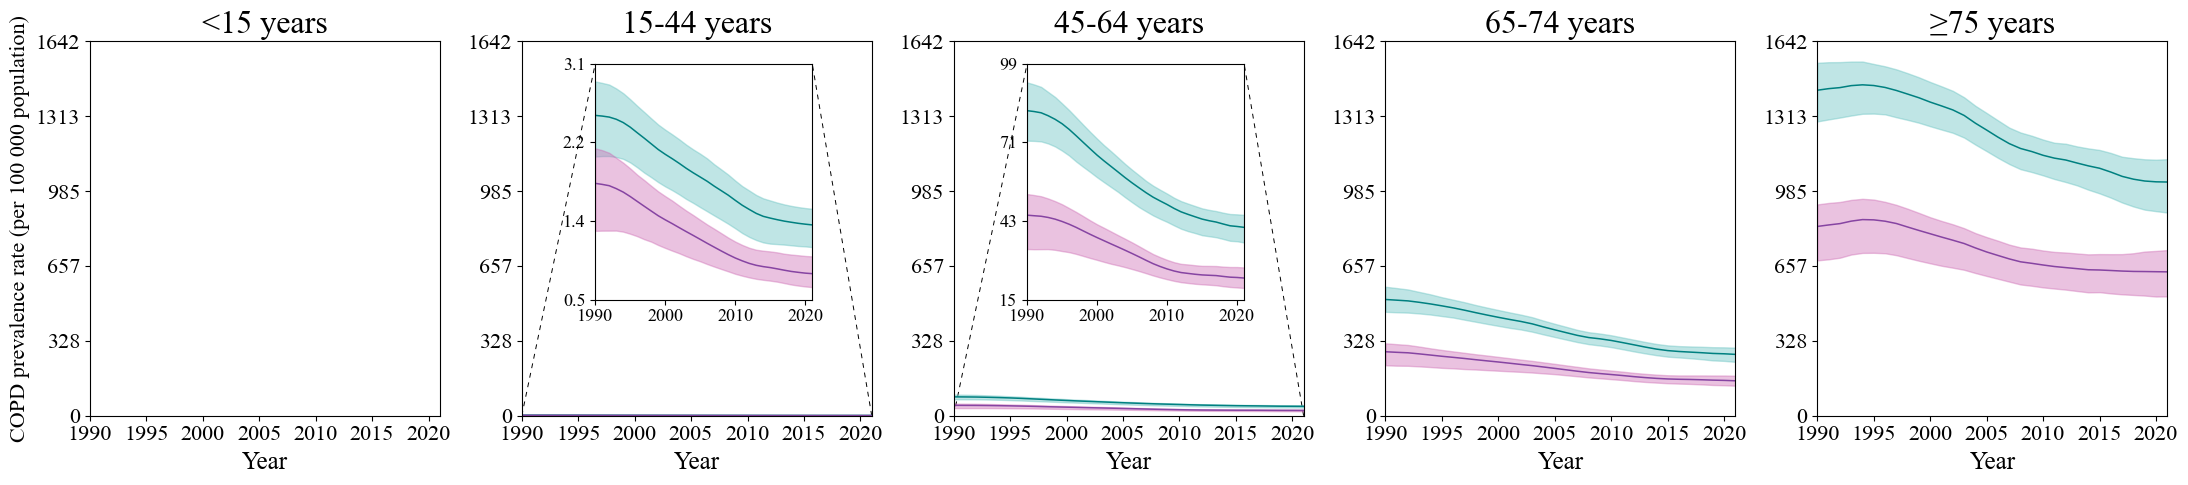

In [131]:
Disease_trends_lineplot_6(509)

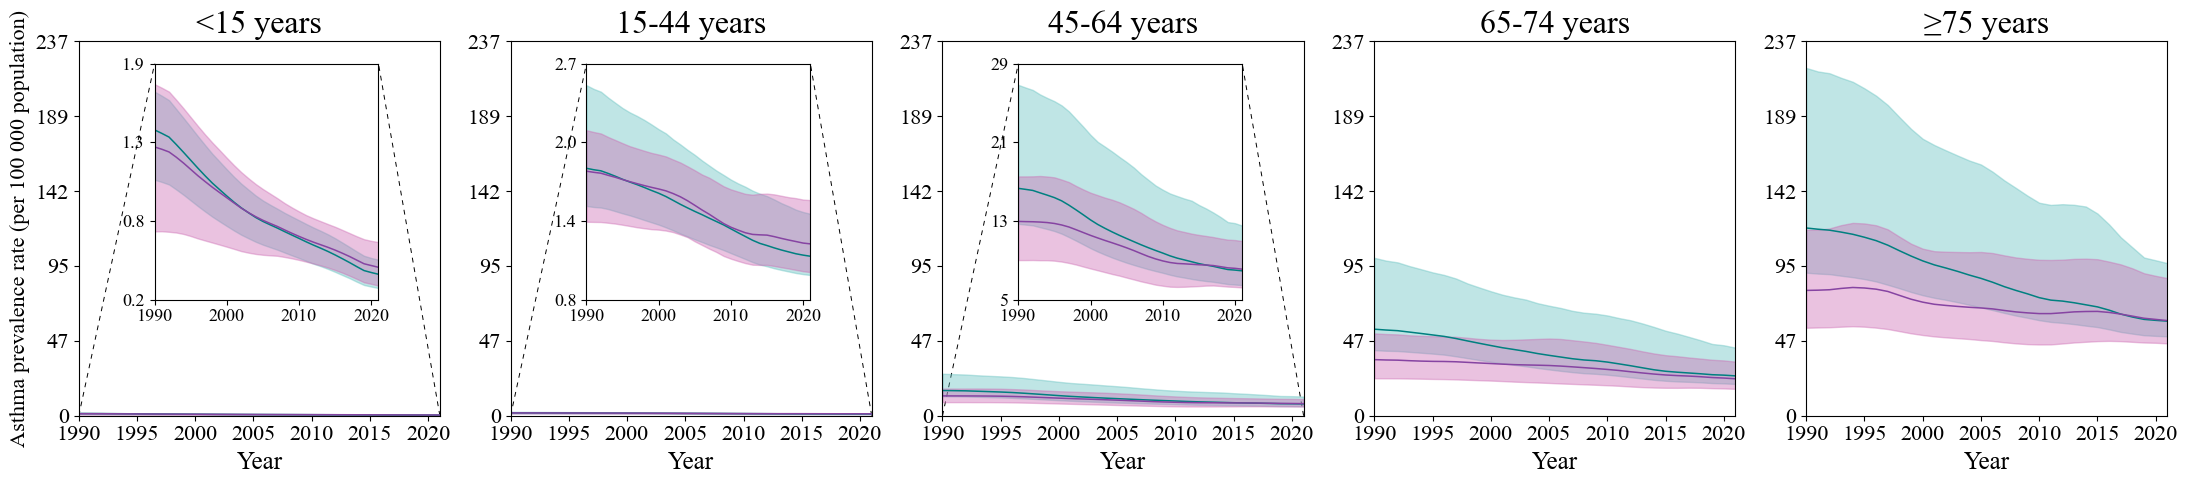

In [132]:
Disease_trends_lineplot_6(515)

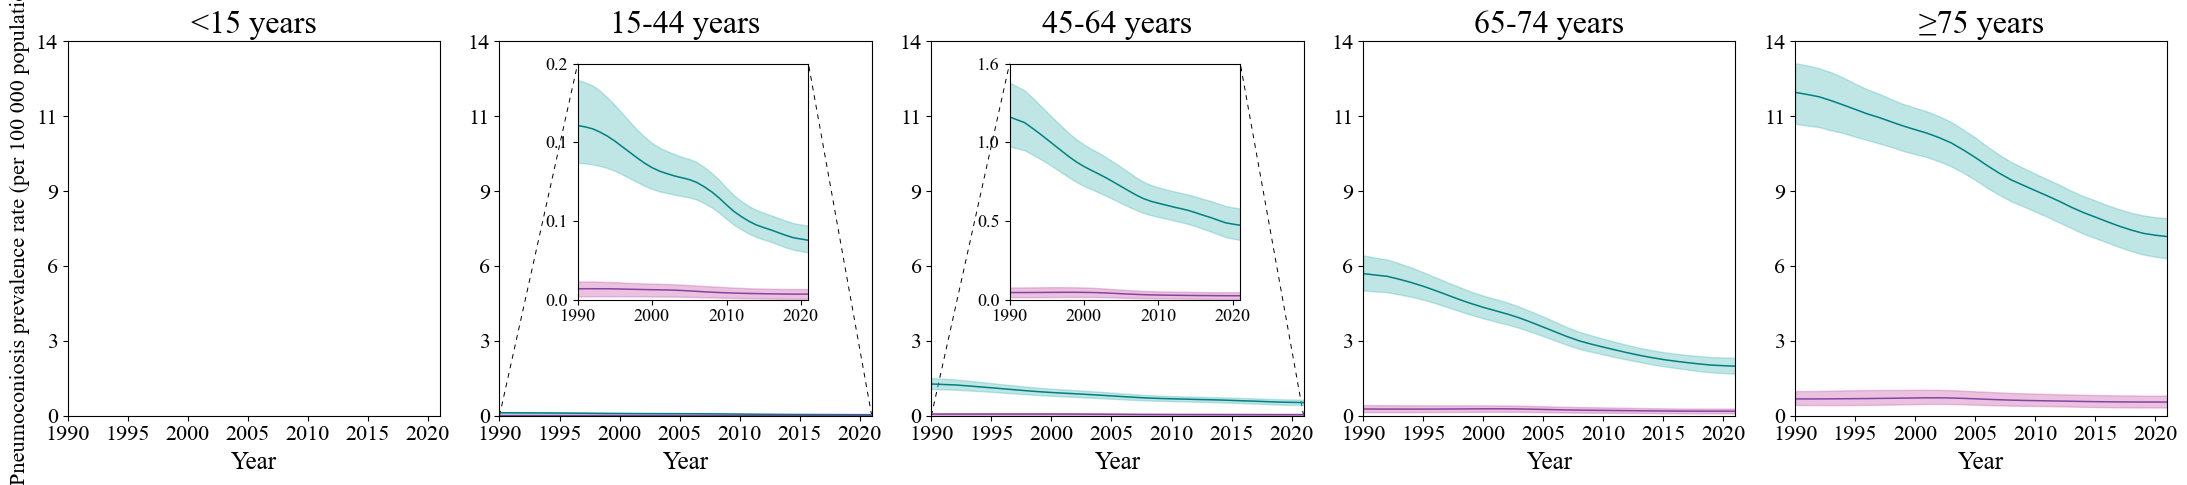

In [133]:
Disease_trends_lineplot_6(510)

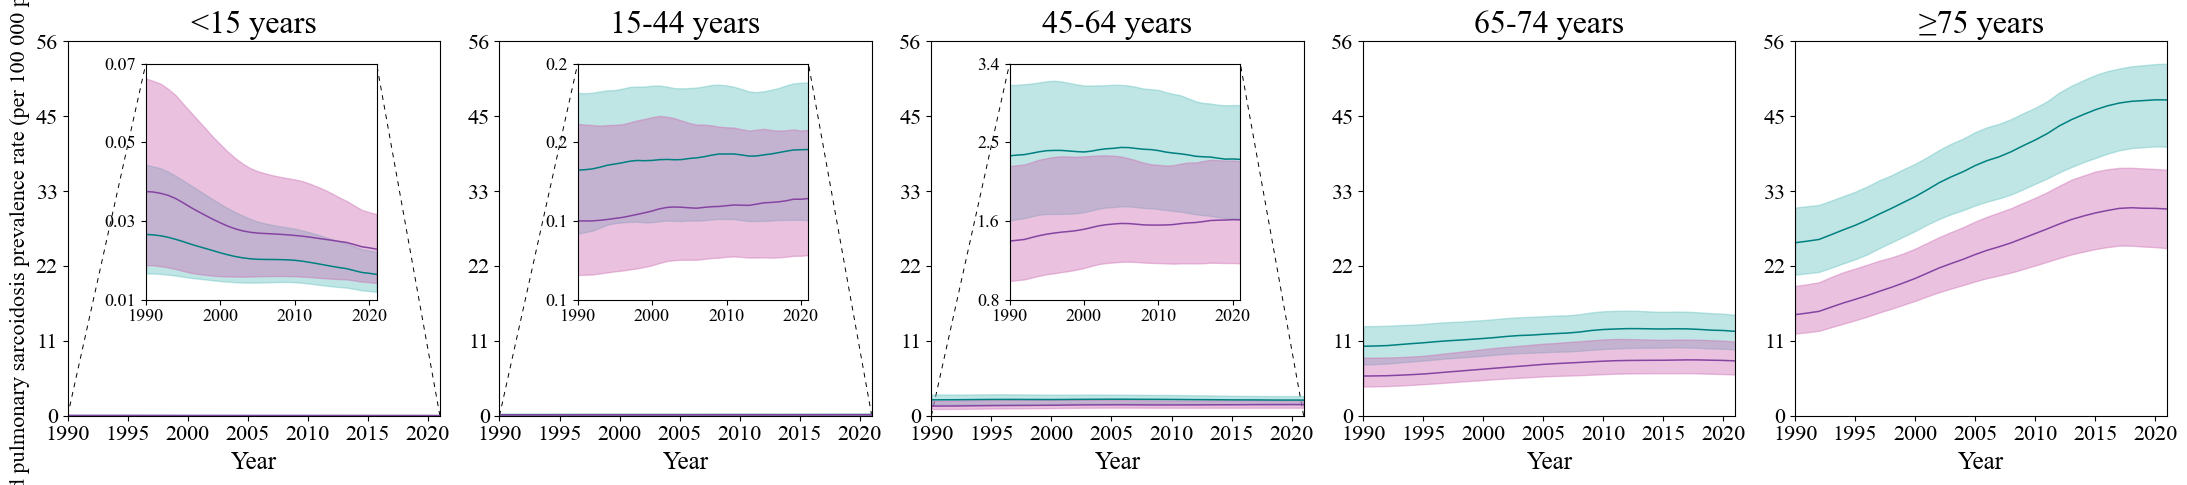

In [136]:
Disease_trends_lineplot_6(516)

# Prevalence

In [ ]:
def Disease_trends_lineplot_6_2(cause_id):
    # cause_id: COPD = 509, Pneumoconiosis = 510, Asthma = 515, ILD = 516
    disease_names = {
        509: "COPD",
        510: "Pneumoconiosis",
        515: "Asthma",
        516: "ILD and pulmonary sarcoidosis"
    }
    
    # Validate cause_id
    if cause_id not in disease_names:
        raise ValueError("Invalid cause_id. Please choose from: {}".format(list(disease_names.keys())))

    # Disease name
    disease_name = disease_names[cause_id]

    # Filter the data
    filtered_data = data[
        (data['cause_id'] == cause_id) & 
        (data['age_group'].isin(['<15 years', '15-44 years', '45-64 years', '65-74 years', '≥75 years']))
    ].copy()

    # Convert numeric columns and handle NaN
    filtered_data['year']   = pd.to_numeric(filtered_data['year'],   errors='coerce')
    filtered_data['val2']   = pd.to_numeric(filtered_data['val2'],   errors='coerce')
    filtered_data['upper2'] = pd.to_numeric(filtered_data['upper2'], errors='coerce')
    filtered_data['lower2'] = pd.to_numeric(filtered_data['lower2'], errors='coerce')
    filtered_data.dropna(subset=['year', 'val2', 'upper2', 'lower2'], inplace=True)

    # Remove duplicates and sort the data
    filtered_data.drop_duplicates(subset=['year', 'sex_name', 'age_group'], inplace=True)
    filtered_data.sort_values(by=['age_group', 'sex_name', 'year'], inplace=True)

    # Define colors for line and fill
    line_colors = {'Male': '#008080', 'Female': '#8644A2'}
    fill_colors = {'Male': '#61C0BF', 'Female': '#CC68B2'}

    # Define age group order
    age_groups = ['<15 years', '15-44 years', '45-64 years', '65-74 years', '≥75 years']

    # Calculate the global maximum upper2 for '≥75 years' age group
    upper75 = filtered_data[filtered_data['age_group'] == '≥75 years']['upper2']
    if upper75.empty:
        raise ValueError("No data available for the '≥75 years' age group.")

    global_max = upper75.max() * 1.05
    global_min = 0

    # Create the plot
    fig, axes = plt.subplots(1, len(age_groups), figsize=(22, 5.5), sharey=False)

    for i, age_group in enumerate(age_groups):
        # Filter data for the specific age group
        age_data = filtered_data[filtered_data['age_group'] == age_group]

        # Main plot data
        for sex in ['Male', 'Female']:
            sex_data = age_data[age_data['sex_name'] == sex]
            if sex_data.empty:
                continue  # Skip if there's no data for this sex in the age group

            # Apply smoothing
            window_size = 5
            sex_data = sex_data.sort_values('year')
            sex_data['val2']   = sex_data['val2'].rolling(window=window_size, center=True, min_periods=1).mean()
            sex_data['lower2'] = sex_data['lower2'].rolling(window=window_size, center=True, min_periods=1).mean()
            sex_data['upper2'] = sex_data['upper2'].rolling(window=window_size, center=True, min_periods=1).mean()

            # Plot on main axes
            axes[i].plot(
                sex_data['year'], 
                sex_data['val2'], 
                label=f"{sex}", 
                color=line_colors[sex], 
                linewidth=1.1
            )
            axes[i].fill_between(
                sex_data['year'], 
                sex_data['lower2'], 
                sex_data['upper2'], 
                color=fill_colors[sex], 
                alpha=0.4, 
                label=f"{sex}, 95% CI"
            )

        # Main axes settings
        axes[i].set_title(age_group, fontsize=23)
        axes[i].set_xlabel("Year", fontsize=18)
        axes[i].set_xlim(1990, 2021)
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(5))

        # Set fixed y-axis limits
        axes[i].set_ylim(global_min, global_max)
        
        # Adjust y-axis formatting
        if global_max < 0.1:
            axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.2f}"))
        elif global_max < 10:
            axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}"))
        else:
            axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(round(x)):,}"))
        axes[i].yaxis.set_major_locator(ticker.LinearLocator(6))
        
        # y-axis label on the first subplot only
        # deaths, prevalence
        if i == 0:
            axes[i].set_ylabel(f"{disease_name} prevalence rate (per 100 000 population)", fontsize=16)  #"\n"
        
        axes[i].tick_params(axis='both', labelsize=16)

        # --------------------------------------------------------------------------
        # Inset Axis : for age groups except '≥75 years' and '65-74 years'
        # --------------------------------------------------------------------------
        if age_group not in ['≥75 years', '65-74 years'] and not age_data.empty:
            ax_inset = axes[i].inset_axes([0.21, 0.33, 0.62, 0.63])  

            y_max_inset = age_data['upper2'].max() * 1.05
            y_min_inset = age_data['lower2'].min() * 0.9

            for sex in ['Male', 'Female']:
                sex_data_inset = age_data[age_data['sex_name'] == sex].copy()
                if sex_data_inset.empty:
                    continue

                sex_data_inset.sort_values('year', inplace=True)
                sex_data_inset['val2']   = sex_data_inset['val2'].rolling(window=window_size, center=True, min_periods=1).mean()
                sex_data_inset['lower2'] = sex_data_inset['lower2'].rolling(window=window_size, center=True, min_periods=1).mean()
                sex_data_inset['upper2'] = sex_data_inset['upper2'].rolling(window=window_size, center=True, min_periods=1).mean()

                ax_inset.plot(
                    sex_data_inset['year'], 
                    sex_data_inset['val2'], 
                    color=line_colors[sex], 
                    linewidth=1.1
                )
                ax_inset.fill_between(
                    sex_data_inset['year'], 
                    sex_data_inset['lower2'], 
                    sex_data_inset['upper2'], 
                    color=fill_colors[sex], 
                    alpha=0.4
                )

            ax_inset.set_xlim(1990, 2021)
            ax_inset.xaxis.set_major_locator(ticker.MultipleLocator(10))
            ax_inset.set_ylim(y_min_inset, y_max_inset)

            ax_inset.set_xlabel('')
            ax_inset.set_ylabel('')

            # Formatting the y-axis for Inset
            if y_max_inset < 0.1:
                ax_inset.yaxis.set_major_formatter(
                    plt.FuncFormatter(lambda x, _: f"{x:.2f}")
                )
            elif y_max_inset < 10:
                ax_inset.yaxis.set_major_formatter(
                    plt.FuncFormatter(lambda x, _: f"{x:.1f}")
                )
            else:
                ax_inset.yaxis.set_major_formatter(
                    plt.FuncFormatter(lambda x, _: f"{int(round(x)):,}")
                )
            
            ax_inset.yaxis.set_major_locator(LinearLocator(4))
            ax_inset.tick_params(axis='both', labelsize=13)

            # ------------------------------------------------------------
            # Main plot bottom corner ↔ Inset plot top corner connecting dotted line
            # ------------------------------------------------------------
            # 1) Lower left corner (0, 0) → Upper left corner of the inset
            line_left = mlines.Line2D(
                xdata = [0, 0.21],
                ydata = [0.15, 0.33 + 0.63],
                transform = axes[i].transAxes,  # Based on the axis coordinate system
                color='k',                      # black
                linestyle='--',                 # dotted line
                linewidth=0.7,                  # Thickness
                dashes=(5, 5),                  # Desic spacing
                zorder=0                        # If the zorder of the axis (ax), tick (tick), and label (label) is set to 2 or 3, the dotted line can be made to pass behind the tick label.
            )
            axes[i].add_line(line_left)

            # 2) Lower right corner (1, 0) → Upper right corner of the inset
            line_right = mlines.Line2D(
                xdata = [1, 0.21 + 0.62],
                ydata = [0.15, 0.33 + 0.63],
                transform = axes[i].transAxes,
                color='k',
                linestyle='--',
                linewidth=0.7,
                dashes=(5, 5),
                zorder=0 
            )
            axes[i].add_line(line_right)

    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

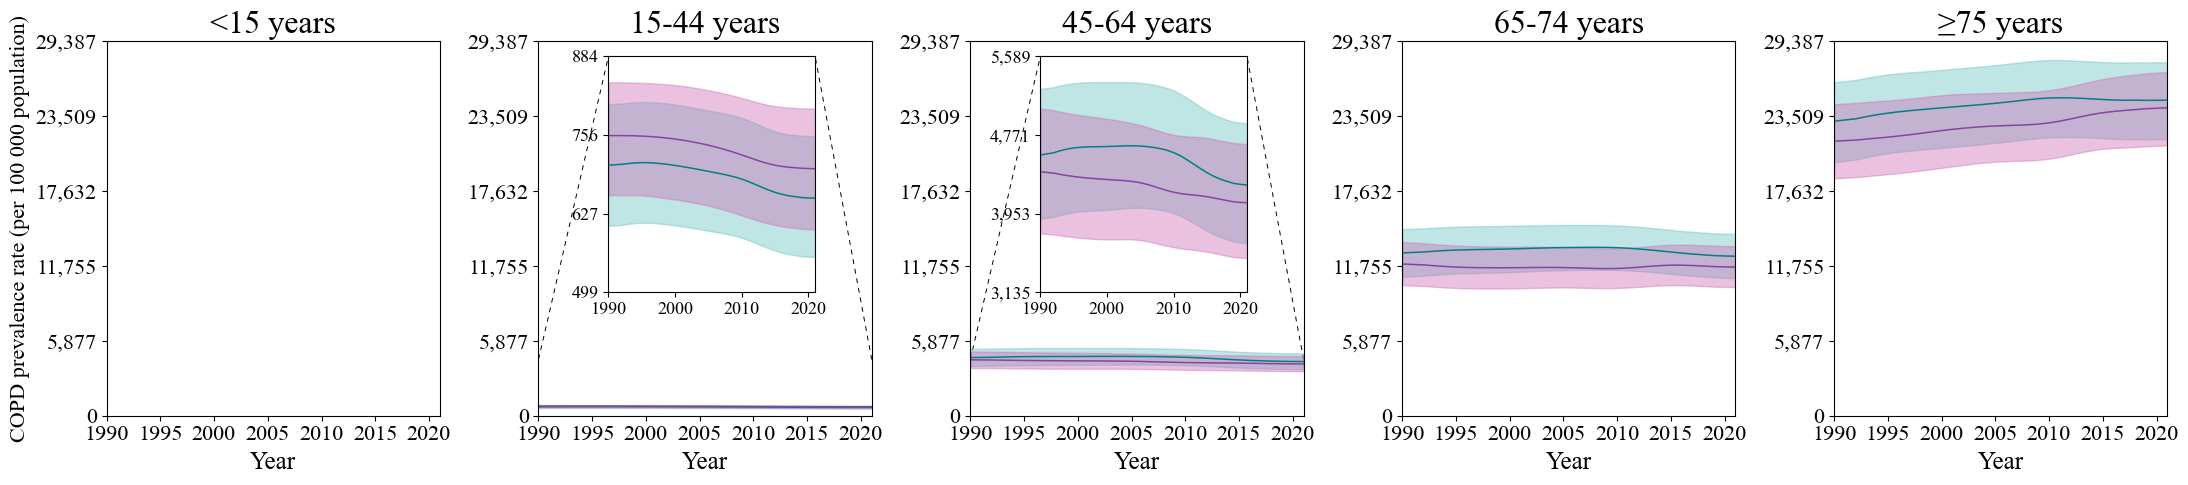

In [224]:
Disease_trends_lineplot_6_2(509)

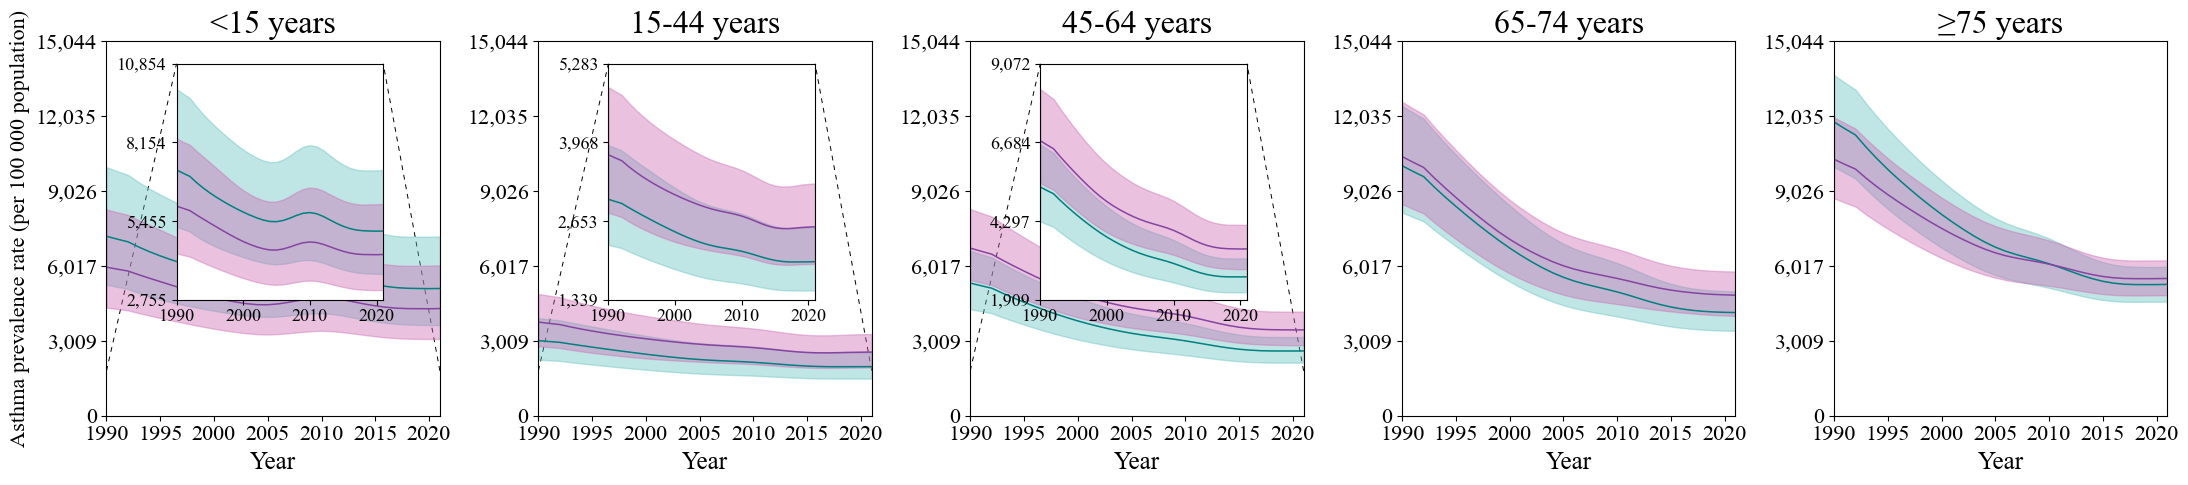

In [175]:
Disease_trends_lineplot_6_2(515)

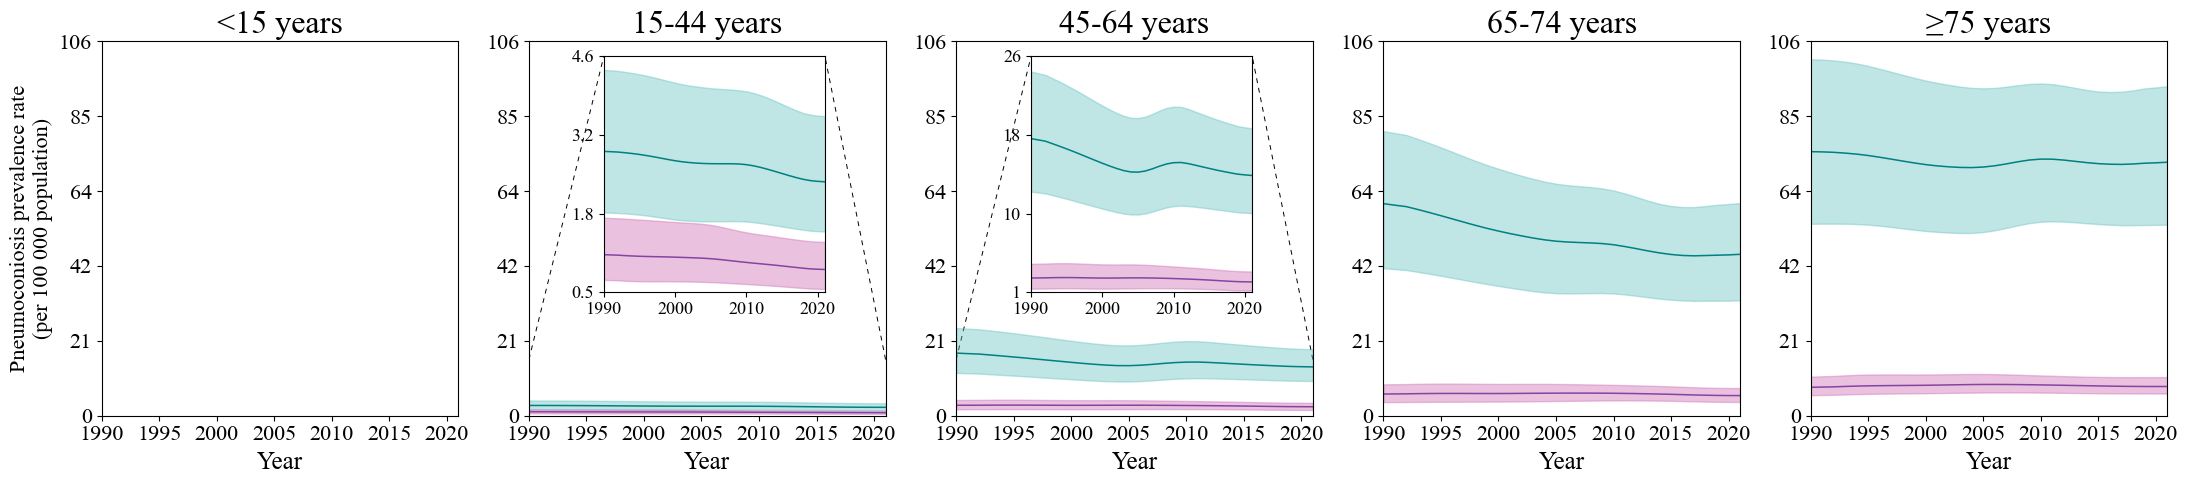

In [213]:
Disease_trends_lineplot_6_2(510)

C:\Users\user\AppData\Local\Temp\ipykernel_16632\2341856187.py:146: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax_inset.set_ylim(y_min_inset, y_max_inset)


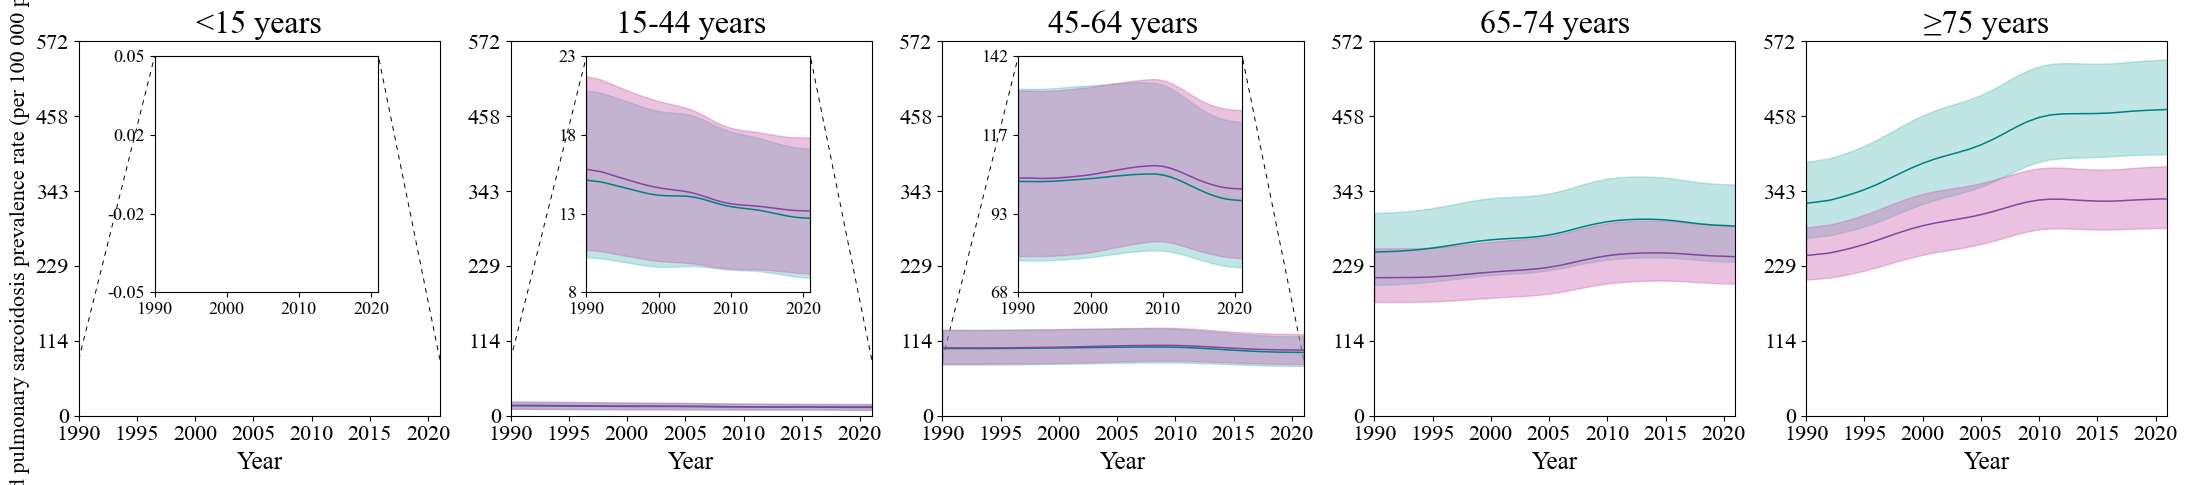

In [222]:
Disease_trends_lineplot_6_2(516)